In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
import gtsam.utils.plot as gtsam_plot

: 

In [3]:
def convert_vec_gtsam_pose3(trans, quat, mode='xyzw'):
    from scipy.spatial.transform import Rotation
    if mode=='xyzw':
        pose3 = gtsam.Pose3(gtsam.Rot3(quat[3], quat[0], quat[1], quat[2]), trans)
    else:
        pose3 = gtsam.Pose3(gtsam.Rot3(quat[0], quat[1], quat[2], quat[3]), trans)
    return pose3

In [4]:
data_folder = '../../../data/utils_algorithm'

# Load odometry (20hz)
poses_depth_reg = np.loadtxt(data_folder + '/poses_odometry.txt')[::1]
depth_reg_gtsam_pose3_list = [convert_vec_gtsam_pose3(pose[1:4], pose[4:]) for pose in poses_depth_reg]
print(f'Number of Depth Reg poses: {len(depth_reg_gtsam_pose3_list)}')

# Load localization and low-rate odometry (1hz)
poses_vloc = np.loadtxt(data_folder + '/poses_localization.txt')
vloc_gtsam_pose3_list = []
for pose in poses_depth_reg:
    # Find the closest localization by comparing pose[0]
    idx = np.argmin(np.abs(poses_vloc[:, 0] - pose[0]))
    time_dis = np.min(np.abs(poses_vloc[:, 0] - pose[0]))
    if time_dis < 0.01:
        vloc_gtsam_pose3_list.append(convert_vec_gtsam_pose3(poses_vloc[idx, 1:4], poses_vloc[idx, 4:]))
    else:
        vloc_gtsam_pose3_list.append(gtsam.Pose3())
print(f'Number of VLOC poses: {len(vloc_gtsam_pose3_list)}')

# Load gt odometry
poses_gt = np.loadtxt(data_folder + '/poses_gt.txt')
gt_gtsam_pose3_list = []
for pose in poses_depth_reg:
    # Find the closest localization by comparing pose[0]
    idx = np.argmin(np.abs(poses_gt[:, 0] - pose[0]))
    time_dis = np.min(np.abs(poses_gt[:, 0] - pose[0]))
    if time_dis < 0.01:
        gt_gtsam_pose3_list.append(convert_vec_gtsam_pose3(poses_gt[idx, 1:4], poses_gt[idx, 4:]))
    else:
        gt_gtsam_pose3_list.append(gtsam.Pose3())
print(f'Number of GT poses: {len(gt_gtsam_pose3_list)}')

cnt = 0
for i in range(len(vloc_gtsam_pose3_list)):
    if not vloc_gtsam_pose3_list[i].equals(gtsam.Pose3(), 1e-3):
        cnt += 1
print('Number of poses with VLOC results:', cnt)

cnt = 0
for i in range(len(vloc_gtsam_pose3_list)):
    if not gt_gtsam_pose3_list[i].equals(gtsam.Pose3(), 1e-3):
        cnt += 1
print('Number of poses with GT:', cnt)


Number of Depth Reg poses: 1482
Number of VLOC poses: 1482
Number of GT poses: 1482
Number of poses with VLOC results: 238
Number of poses with GT: 1404


Initial error: 4.715569312356576
Result error: 0.009660491220958045
Maximize trace: 0.8116458199009073


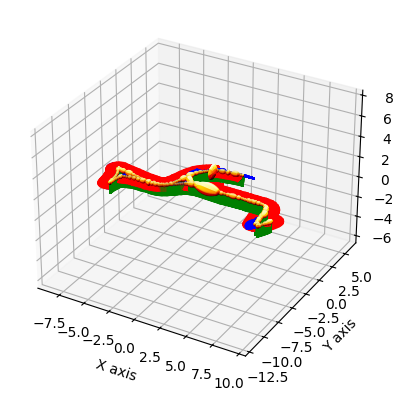

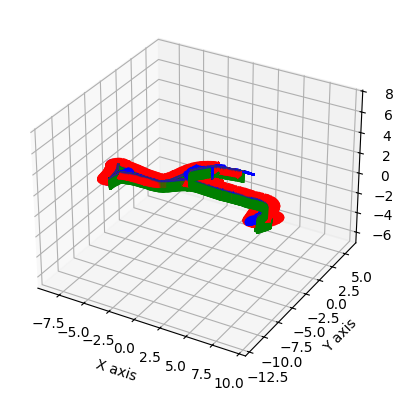

In [5]:
# Batch Optimization
graph = gtsam.NonlinearFactorGraph()

# Add prior on the first pose
PriorFactor = gtsam.PriorFactorPose3
for i in range(len(depth_reg_gtsam_pose3_list)):
    if not vloc_gtsam_pose3_list[i].equals(gtsam.Pose3(), 1e-3):
        prior_cov = gtsam.noiseModel.Diagonal.Sigmas(np.array([np.deg2rad(1.), np.deg2rad(1.), np.deg2rad(1.), 0.01, 0.01, 0.01]))
        graph.add(PriorFactor(i, vloc_gtsam_pose3_list[i], prior_cov))

# Create odometry factors
odometry_cov = gtsam.noiseModel.Diagonal.Sigmas(np.array([np.deg2rad(5.), np.deg2rad(5.), np.deg2rad(5.), 0.05, 0.05, 0.01]))
BetweenFactor = gtsam.BetweenFactorPose3
for i in range(1, len(depth_reg_gtsam_pose3_list)):
    odometry_factor = BetweenFactor(i-1, i, depth_reg_gtsam_pose3_list[i-1].between(depth_reg_gtsam_pose3_list[i]), odometry_cov)
    graph.add(odometry_factor)

# Create the initial estimate
initial_estimate = gtsam.Values()
for i in range(len(depth_reg_gtsam_pose3_list)):
    initial_estimate.insert(i, vloc_gtsam_pose3_list[i])

for i in range(initial_estimate.size()):
    gtsam_plot.plot_pose3(0, initial_estimate.atPose3(i), 1)
plt.axis('equal'); 

#| caption: Factor graph with odometry and loop closure constraints.
#| label: fig:factor_graph_with_loop_closure
# show(graph, initial_estimate, binary_edges=True)
    
# Optimize the initial values using a Gauss-Newton nonlinear optimizer
optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate)
result = optimizer.optimize()
ini_error, res_error = [], []

marginals = gtsam.Marginals(graph, result)
mag = []
for i in range(len(depth_reg_gtsam_pose3_list)):
    if gt_gtsam_pose3_list[i].equals(gtsam.Pose3(), 1e-3): continue
    ini_error.append(np.linalg.norm(initial_estimate.atPose3(i).translation() - gt_gtsam_pose3_list[i].translation()))
    res_error.append(np.linalg.norm(result.atPose3(i).translation() - gt_gtsam_pose3_list[i].translation()))
    mag.append(np.trace(marginals.marginalCovariance(i)))

print("Initial error: {}".format(np.mean(ini_error)))
print("Result error: {}".format(np.mean(res_error)))
print("Maximize trace: {}".format(np.max(mag)))

#| caption: The optimized trajectory with the estimated covariances.
#| label: fig:optimized_trajectory_with_covariances
for i in range(len(depth_reg_gtsam_pose3_list)):
    gtsam_plot.plot_pose3(0, result.atPose3(i), 1, marginals.marginalCovariance(i))
plt.axis('equal'); 

for i in range(len(depth_reg_gtsam_pose3_list)):
    gtsam_plot.plot_pose3(1, gt_gtsam_pose3_list[i], 1)
plt.axis('equal'); 

plt.show()


Result error: 0.025418172301790665


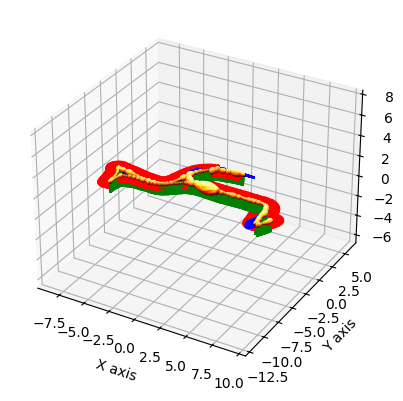

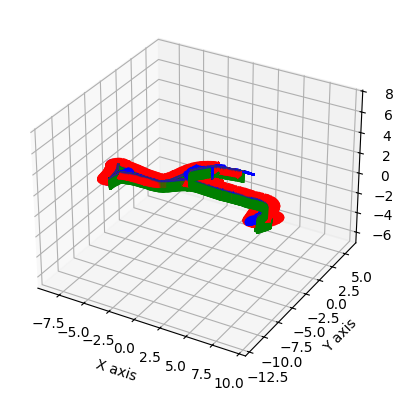

In [14]:
import time

# Incremental Optimization

graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

# Create iSAM2 parameters which can adjust the threshold necessary to force relinearization and how many
# update calls are required to perform the relinearization.
# parameters = gtsam.ISAM2Params()
# parameters.setRelinearizeThreshold(0.3)
# parameters.relinearizeSkip = 5
# isam = gtsam.ISAM2(parameters)
isam = gtsam.ISAM2()
    
# Define Faector
PriorFactor = gtsam.PriorFactorPose3
prior_cov = gtsam.noiseModel.Diagonal.Sigmas(np.array([np.deg2rad(1.), np.deg2rad(1.), np.deg2rad(1.), 0.01, 0.01, 0.01])) # rotation and translation

BetweenFactor = gtsam.BetweenFactorPose3
odometry_cov = gtsam.noiseModel.Diagonal.Sigmas(np.array([np.deg2rad(5.), np.deg2rad(5.), np.deg2rad(5.), 0.05, 0.05, 0.01]))

# Incrementally add factor
graph.add(PriorFactor(0, vloc_gtsam_pose3_list[0], prior_cov))
initial_estimate.insert(0, vloc_gtsam_pose3_list[0])

current_estimate = initial_estimate
for i in range(1, len(depth_reg_gtsam_pose3_list)):
	# add valid prior factor
	if not vloc_gtsam_pose3_list[i].equals(gtsam.Pose3(), 1e-3):
		graph.add(PriorFactor(i, vloc_gtsam_pose3_list[i], prior_cov))
	# add odometry factor
	graph.add(BetweenFactor(i-1, i, depth_reg_gtsam_pose3_list[i-1].between(depth_reg_gtsam_pose3_list[i]), odometry_cov))
	initial_estimate.insert(i, vloc_gtsam_pose3_list[i])
	# Check whether to update iSAM 2
	if i % 10 == 0 or i == len(depth_reg_gtsam_pose3_list) - 1:
		start_time = time.time()
		isam.update(graph, initial_estimate)
		current_estimate = isam.calculateEstimate()
		graph.resize(0)
		initial_estimate.clear()
		# print(f"Update time: {time.time() - start_time:03f}s")
marginals = gtsam.Marginals(graph, current_estimate)

# Check the final result
res_error = []
for i in range(len(depth_reg_gtsam_pose3_list)):
	if gt_gtsam_pose3_list[i].equals(gtsam.Pose3(), 1e-3): continue
	res_error.append(np.linalg.norm(current_estimate.atPose3(i).translation() - gt_gtsam_pose3_list[i].translation()))
print("Result error: {}".format(np.mean(res_error)))

for i in range(len(depth_reg_gtsam_pose3_list)):
	gtsam_plot.plot_pose3(0, result.atPose3(i), 1, isam.marginalCovariance(i))
plt.axis('equal'); 

for i in range(len(depth_reg_gtsam_pose3_list)):
	gtsam_plot.plot_pose3(1, gt_gtsam_pose3_list[i], 1)
plt.axis('equal'); 

plt.show()
